In [ ]:
from collections import OrderedDict
from functools import partial
import glob

import joypy
import librosa
import librosa.display
import scipy
from scipy import signal
from scipy.io import wavfile
import tftb

from util import *
from util import _unpack_input

figsize('inline_short')
None

In [ ]:
# Load audio paths
audio_paths = pd.DataFrame([
    OrderedDict(
        source=path.split('/')[-4],
        species_code=path.split('/')[-3],
        title=os.path.splitext(path.split('/')[-1])[0],
        path=path,
    )
    for path in glob.glob(f'{peterson_dir}/*/audio/*')
])
display(
    audio_paths[:5],
    audio_paths.groupby(['source', 'species_code']).count(),
)

,source,species_code,title,path
0,peterson-field-guide,bewwre,43220301 Song,/Users/danb/hack/bubo/data/peterson-field-guide/bewwre/audio/43220301 Song.mp3
1,peterson-field-guide,bewwre,43220321 Song,/Users/danb/hack/bubo/data/peterson-field-guide/bewwre/audio/43220321 Song.mp3
2,peterson-field-guide,bewwre,43220351 Song,/Users/danb/hack/bubo/data/peterson-field-guide/bewwre/audio/43220351 Song.mp3
3,peterson-field-guide,bewwre,43220371 Song (2 types),/Users/danb/hack/bubo/data/peterson-field-guide/bewwre/audio/43220371 Song (2 types).mp3
4,peterson-field-guide,bewwre,"43220391 Song, Chatter, Snarl, etc.","/Users/danb/hack/bubo/data/peterson-field-guide/bewwre/audio/43220391 Song, Chatter, Snarl, etc..mp3"


title  path
source               species_code             
peterson-field-guide bewwre           19    19
                     bkcchi           19    19
                     blctit4          20    20
                     borchi2          12    12
                     bushti           12    12
                     cacwre           14    14
                     canwre           15    15
                     carchi           18    18
                     carwre           19    19
                     cedwax            7     7
                     houwre           20    20
                     marwre           20    20
                     rebnut           16    16
                     rocwre           13    13
                     sedwre           11    11
                     sonspa           19    19
                     tuftit           26    26
                     whbnut           17    17
                     whcspa           20    20
                     winwre3           9     9
                     wlswar           15    15

In [ ]:
# Load audio from paths
recs_2ch = (audio_paths
    [lambda df: df.species_code == 'wlswar'].reset_index(drop=True)  # For faster dev
    [:5]  # For faster dev
    .assign(audio=lambda df: df.reset_index(drop=True).apply(axis=1, func=lambda rec:
        (
            print(f'Loading audio {rec.name + 1}/{len(df)}: {rec.path}') if rec.name % (np.ceil(len(df) / 5) or 1) == 0 else None,
            audiosegment.from_file(rec.path),
        )[-1]
    ))
)
recs_2ch.audio[:5]

Loading audio 1/5: /Users/danb/hack/bubo/data/peterson-field-guide/wlswar/audio/43231921 Song (2 series).mp3
Loading audio 2/5: /Users/danb/hack/bubo/data/peterson-field-guide/wlswar/audio/43231931 Song (2 series).mp3


Loading audio 3/5: /Users/danb/hack/bubo/data/peterson-field-guide/wlswar/audio/43231951 Song (series).mp3
Loading audio 4/5: /Users/danb/hack/bubo/data/peterson-field-guide/wlswar/audio/43231961 Song (series).mp3
Loading audio 5/5: /Users/danb/hack/bubo/data/peterson-field-guide/wlswar/audio/43231971 Song (1 series, 1 trill).mp3


0             /Users/danb/hack/bubo/data/peterson-field-guide/wlswar/audio/43231921 Song (2 series).mp3: 2 channels, 16 bit, sampled @ 44.1 kHz, 25.809s long
1             /Users/danb/hack/bubo/data/peterson-field-guide/wlswar/audio/43231931 Song (2 series).mp3: 2 channels, 16 bit, sampled @ 44.1 kHz, 25.992s long
2               /Users/danb/hack/bubo/data/peterson-field-guide/wlswar/audio/43231951 Song (series).mp3: 2 channels, 16 bit, sampled @ 44.1 kHz, 23.510s long
3               /Users/danb/hack/bubo/data/peterson-field-guide/wlswar/audio/43231961 Song (series).mp3: 2 channels, 16 bit, sampled @ 44.1 kHz, 20.428s long
4    /Users/danb/hack/bubo/data/peterson-field-guide/wlswar/audio/43231971 Song (1 series, 1 trill).mp3: 2 channels, 16 bit, sampled @ 44.1 kHz, 26.906s long
Name: audio, dtype: object

In [ ]:
recs = (recs_2ch
    .assign(
        # Merge stereo to mono so we don't get confused when handling samples (we don't care about stereo vs. mono)
        audio=lambda df: df.audio.apply(lambda audio:
            audio.resample(channels=1, sample_rate_Hz=standard_sample_rate_hz)
            # audio.set_channels(1)  # TODO Any loss in fidelity by using .resample(channels=1)?
        ),
    )
    .assign(
        # Materialize audio samples
        samples=lambda df: df.audio.map(lambda audio: audio.to_numpy_array()),
    )
    .pipe(df_reorder_cols, last=['path'])
)
recs[:5]

,source,species_code,title,audio,samples,path
0,peterson-field-guide,wlswar,43231921 Song (2 series),"/Users/danb/hack/bubo/data/peterson-field-guide/wlswar/audio/43231921 Song (2 series).mp3: 1 channels, 16 bit, sampled @ 22.05 kHz, 25.809s long",[0 0 0 ... 1 0 0],/Users/danb/hack/bubo/data/peterson-field-guide/wlswar/audio/43231921 Song (2 series).mp3
1,peterson-field-guide,wlswar,43231931 Song (2 series),"/Users/danb/hack/bubo/data/peterson-field-guide/wlswar/audio/43231931 Song (2 series).mp3: 1 channels, 16 bit, sampled @ 22.05 kHz, 25.992s long",[ 0 1 1 ... -1 0 0],/Users/danb/hack/bubo/data/peterson-field-guide/wlswar/audio/43231931 Song (2 series).mp3
2,peterson-field-guide,wlswar,43231951 Song (series),"/Users/danb/hack/bubo/data/peterson-field-guide/wlswar/audio/43231951 Song (series).mp3: 1 channels, 16 bit, sampled @ 22.05 kHz, 23.510s long",[ 0 1 0 ... 0 0 -1],/Users/danb/hack/bubo/data/peterson-field-guide/wlswar/audio/43231951 Song (series).mp3
3,peterson-field-guide,wlswar,43231961 Song (series),"/Users/danb/hack/bubo/data/peterson-field-guide/wlswar/audio/43231961 Song (series).mp3: 1 channels, 16 bit, sampled @ 22.05 kHz, 20.428s long",[1 0 0 ... 0 0 0],/Users/danb/hack/bubo/data/peterson-field-guide/wlswar/audio/43231961 Song (series).mp3
4,peterson-field-guide,wlswar,"43231971 Song (1 series, 1 trill)","/Users/danb/hack/bubo/data/peterson-field-guide/wlswar/audio/43231971 Song (1 series, 1 trill).mp3: 1 channels, 16 bit, sampled @ 22.05 kHz, 26.906s long",[0 0 0 ... 0 0 0],"/Users/danb/hack/bubo/data/peterson-field-guide/wlswar/audio/43231971 Song (1 series, 1 trill).mp3"


In [ ]:
# Names for easier dev (better autocomplete)
rec0 = recs.iloc[0]
audio0 = rec0.audio

In [ ]:
# TODO How big of audio signals do we actually need to deal with?
#   - How does pytftb structure its sampling for ACF/WVD?
#   - [This was related to my scipy.signal.correlation attempt elsewhere, which was wrong-headed and I'm throwing away]
f, t, S = spectro(audio0, nperseg=512, overlap=0.5)
display(
    # The raw signal is big
    audio0.to_numpy_array().shape,
    # But these spectrogram outputs are not big...
    f.shape,
    t.shape,
    S.shape,
)

(569088, )

(257, )

(2222, )

(257, 2222)

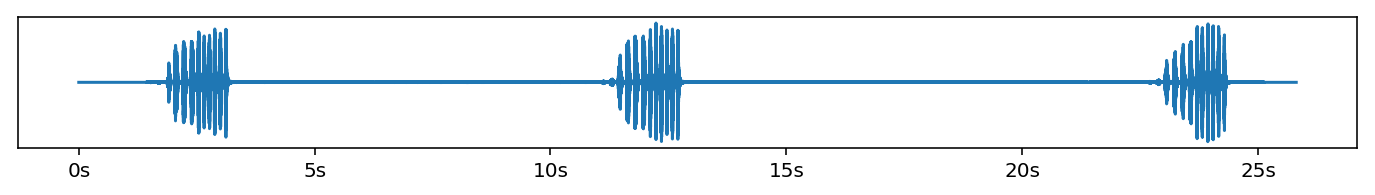

In [ ]:
with with_figsize(aspect_ratio=1/10):
    plt_audio_signal(audio0)
    plt.show()

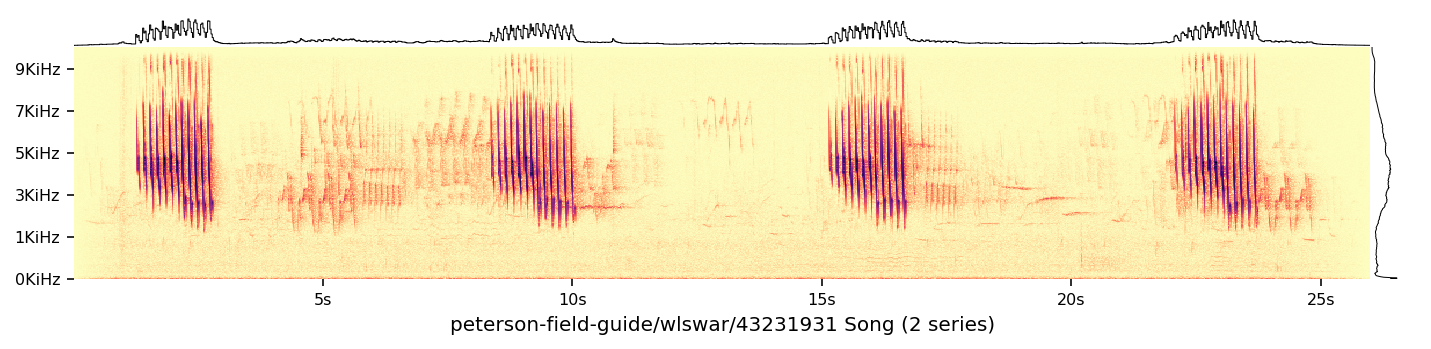

/Users/danb/hack/bubo/data/peterson-field-guide/wlswar/audio/43231931 Song (2 series).mp3: 1 channels, 16 bit, sampled @ 22.05 kHz, 25.992s long

In [ ]:
from util import *
with with_figsize(aspect_ratio=1/5):
    recs[1:2].apply(axis=1, func=lambda rec: (
        plt_spectro(rec, nperseg=1024, overlap=0.5, fancy=True),
        plt.show(),
    ))

In [ ]:
from util import *
figsize(aspect_ratio=1/2)
# TODO
#   - [x] Plot a cepstrum (spectrum(x) = FT(x), cepstrum(x) = IFT(log(abs(FT(x)))))
#   - [ ] Grid these plots wide-ly and then plot a handful of different audios for comparison!

rec, _, x, sample_rate = _unpack_input(audio0)

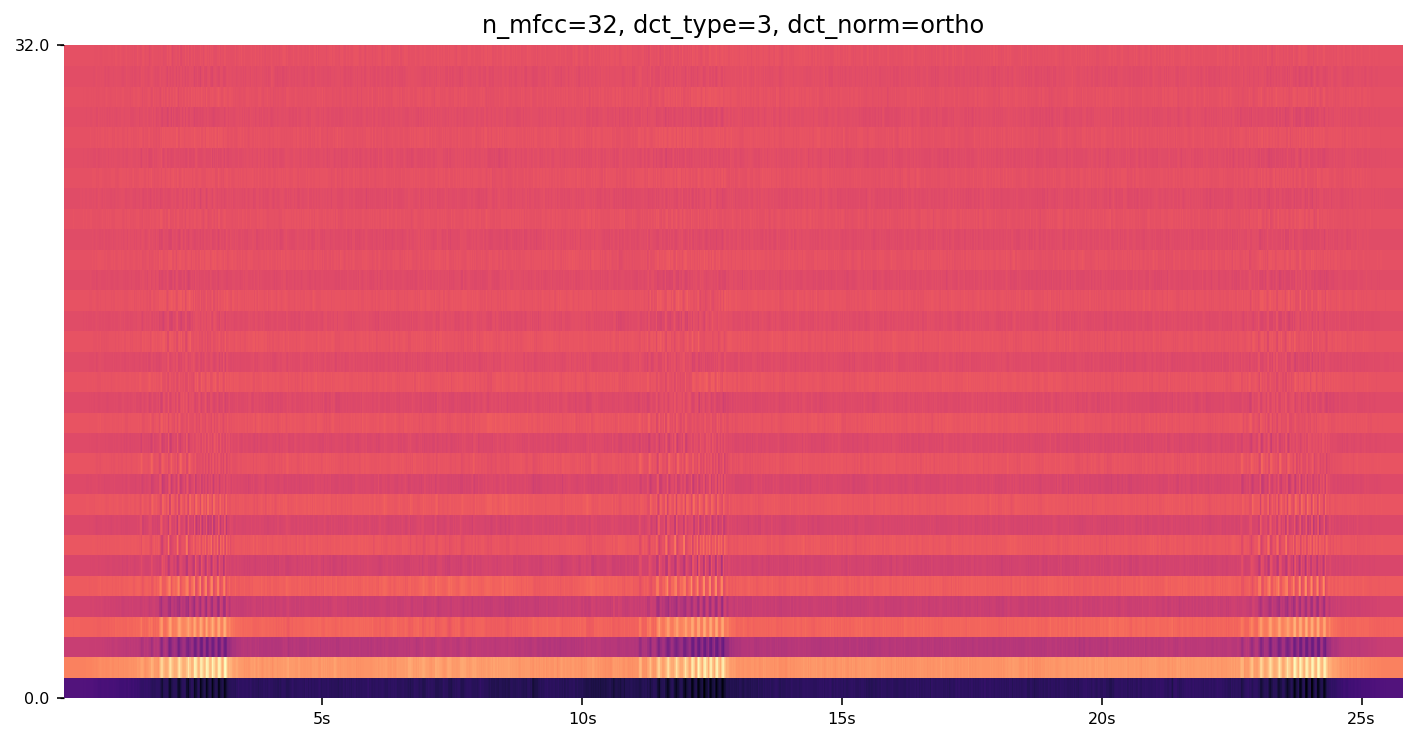

In [ ]:
# TODO Done! mfcc looks like librosa (except librosa is lower resolution on t axis, and we don't care why). Next:
#   - [ ] Compare dct3 (idct) vs. dct2 (dct), since mfcc is supposed to be idct, not dct
#   - [ ] Clean up mfcc / plt_mfcc
#   - [ ] Pop the stack
n_mfcc = 32
dct_type = 3
dct_norm = 'ortho'
std = False
plt_mfcc(x, dct_type=dct_type, dct_norm=dct_norm, mfcc=partial(mfcc, mels_div=2, first_n_mfcc=n_mfcc, std=std), show_audio=False, fancy=False)
plt.title(f'n_mfcc={n_mfcc}, dct_type={dct_type}, dct_norm={dct_norm}')  # XXX
plt.show()

# M = librosa.feature.mfcc(x.astype(float), sample_rate, n_mfcc=n_mfcc)
# M = (M - M.mean(axis=1)[:, np.newaxis]) / M.std(axis=1)[:, np.newaxis]  # Standardize
# plt.pcolormesh(M)
# plt.gca().yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%5d'))
# plt.gca().tick_params(labelsize=8)
# [s.set_visible(False) for s in plt.gca().spines.values()]
# plt.show()

In [ ]:
# TODO Try denoising: smoothing and/or filtering
def zero_below(S, perc=75):
    out = S.copy()
    for ST, outT in [(S, out), (S.T, out.T)]:
        for i in range(ST.shape[0]):
            outT[i][ST[i] < np.percentile(ST[i], perc)] = 0
    return out

def zero_below_all(S, perc=75):
    out = S.copy()
    out[out < np.percentile(S, perc)] = 0
    return out

def smooth(S, kernel_size=3):
    return scipy.signal.medfilt(S, kernel_size=kernel_size)

with with_figsize(aspect_ratio=1/8):
    audio = audio0[1000:3000]
    f, t, S = spectro(audio, nperseg=256, overlap=.9)
    display(S.shape)
    S_log1p = np.log1p(S)
    kernel_size = 5
    perc = 1
    # plt.pcolormesh(t, f, np.log(S)); plt.show()
    plt.pcolormesh(t, f, S_log1p); plt.show()
    # plt.pcolormesh(t, f, zero_below(S_log1p)); plt.show()
    # plt.pcolormesh(t, f, smooth(S_log1p)); plt.show()
    # plt.pcolormesh(t, f, zero_below(smooth(S_log1p))); plt.show()
    # plt.pcolormesh(t, f, smooth(zero_below(S_log1p))); plt.show()

In [ ]:
# TODO What is FT(acf(x))? This seems like a common technique.
with with_figsize(aspect_ratio=1/8):

    x = audio0[1000:3000].to_numpy_array()
    y = scipy.signal.correlate(x, x, mode='same')
    yH = len(y) // 2
    y = y[yH-500:yH+500]
    display(
        x.shape,
        y.shape,
        # audiosegment.from_numpy_array(x, 22050),
    )

    # XXX Some crap (corr directly on the visual spectros)
    # f, t, S = spectro(x, nperseg=256, overlap=.9)
    # S = np.abs(S)
    # acorr_in = S
    # aS = scipy.signal.correlate(acorr_in, acorr_in, mode='same')
    # display(
    #     S.shape,
    #     aS.shape,
    # )
    # plt.pcolormesh(t, f, np.abs(S)); plt.show()
    # plt.pcolormesh(t, f, np.abs(aS)); plt.show()
    # plt.pcolormesh(t, f, np.log(np.abs(S))); plt.show()
    # plt.pcolormesh(t, f, np.log(np.abs(aS))); plt.show()
    # plt.pcolormesh(t, f, np.log1p(np.abs(S))); plt.show()
    # plt.pcolormesh(t, f, np.log1p(np.abs(aS))); plt.show()

    plt_signal(x); plt.show()
    plt.plot((np.abs(np.fft.rfft(x)) / 22050)**2 / 2); plt.show()
    plt.plot(*scipy.signal.periodogram(x, fs=22050, scaling='spectrum')); plt.show()
    plt_spectro(x, nperseg=256, overlap=.9); plt.show()
    plt_signal(y); plt.show()
    plt.plot((np.abs(np.fft.rfft(y)) / 22050)**2 / 2); plt.show()
    plt.plot(*scipy.signal.periodogram(y, fs=22050, scaling='spectrum')); plt.show()
    plt_spectro(y, nperseg=32, overlap=.95); plt.show()  # [Why isn't plt_spectro as good as plt.specgram?]
    plt.specgram(y, NFFT=50, noverlap=49, Fs=22050); plt.show()

In [ ]:
# def ambiguity_function_via_spectro(x):
"""
A fast ambiguity function for signal x via 2D-FT on its (STFT) spectrogram:
    A_x(ν,τ) = FT_{t->ν}(IFT_{τ<-f}(S_x(t,f)))

This approach mimics QTFD relationship between the ambiguity function and WVD, which is slow to compute:
    A_z(ν,τ) = FT_{t->ν}(IFT_{τ<-f}(W_z(t,f)))
"""

f, t, S = spectro(
    audio0[2000:3000],
    nperseg=256,
    overlap=0.8,
)
display(
    t.shape,
    f.shape,
    S.shape,
)

plt.pcolormesh(t, f, np.log(S))
plt.show()

In [ ]:
# TODO A_x(ν,τ) = FT_{t->ν}(IFT_{τ<-f}(S_x(t,f)))
# A = np.abs(S)
# A = np.fft.fft2(S)  # Junk?
# A = np.fft.fft2(np.abs(S))  # Hint of not junk...
# A = np.fft.fft2(np.log(np.abs(S)))  # Junk?
# A = np.fft.fft(axis=1, a=np.fft.ifft(axis=0, a=S))  # Junk?
A = np.fft.fft(axis=1, a=np.fft.ifft(axis=0, a=np.abs(S)))  # Looks similar to fft2, above... maybe not junk?
# A = np.fft.fft(axis=1, n=1*S.shape[1], a=np.fft.ifft(axis=0, n=1*S.shape[0], a=np.abs(S)))  # Better borders?
# A = np.fft.fft(axis=1, n=8*S.shape[1], a=np.fft.ifft(axis=0, n=8*S.shape[0], a=np.abs(S)))  # Better borders?
# A = np.fft.fft(axis=1, a=np.fft.ifft(axis=0, a=np.log(np.abs(S))))  # Junk?
# TODO TODO Is we being drowned out by noise...? Next step: try on a toy signal with higher res and less noise!
plt.pcolormesh(
    # np.abs(A),
    np.log(np.abs(A)),
)
plt.show()

In [ ]:
# TODO Dev above
# tau = ...
# nu = ...
# af = ...

# with with_figsize('inline'):
#     # plt.pcolormesh(tau, nu, af)  # TODO
#     plt.show()

In [ ]:
audio0_sub = audio0[:100]  # wide_band[6.8s]
# audio0_sub = audio0[1000:4000]
# audio0_sub = audio0[2000:2500]
# audio0_sub = audio0[1000:3000]  # .6s vs. 4s
# audio0_sub = audio0[0000:5000]  # .7s vs. 9s
x = audio0_sub.to_numpy_array()
x_sample_rate = audio0_sub.frame_rate
display(x.shape)
plt.plot(x)

In [ ]:
%%time
with with_figsize(aspect_ratio=1/5):
    plt_spectro(x, nperseg=512, overlap=0.5, fancy=True, show_audio=False)
    plt.show()

In [ ]:
%%time
from tftb.processing.ambiguity import narrow_band, wide_band
waf, lag, doppler = wide_band(x, fmin=None, fmax=None, N=None)
display(
    waf.shape,
    lag.shape,
    doppler.shape,
)

In [ ]:
# TODO Downsample x before computing the AF!
np.abs(waf[:10,:10])
# plt.pcolormesh(lag, doppler, np.abs(waf) ** 1)  # TODO Blank plot...
# TODO Both plt.pcolormesh and plt.contour go blank somewhere between i=4000 -> i=5000...
with with_figsize('inline'):
    i, j = 4000, 2205
    plt.contour(lag[:j], doppler[:i], np.abs(waf)[:i,:j])
    plt.show()

In [ ]:
# XXX PRETTY SLOW. don't use their spectrogram implementation
# fwindow = signal.hamming(65)
# %time spec = tftb.processing.Spectrogram(x, n_fbins=128, fwindow=fwindow); spec.run()
# spec.plot(kind='contour', threshold=0.1, show_tf=False)

In [ ]:
# XXX SLOW AS FUCK, AND BLOWS UP RAM!
# %time wvd = tftb.processing.WignerVilleDistribution(x); wvd.run()
# wvd.plot(kind='cmap')